# ECE 445 (ML for ENGG): Credit Card Fraud Detection

*Eric Jiang ewj12 158002948*

12/14/2018

This dataset contains transactions from European credit cards in September 2013. 

The variables are unknown due to confidentiality issues.

*The only known variables are:*

**Time** - Time it takes to reach final transaction

**Amount** - Amount in the transaction

**Class** - Determines if fraud (1) or non-fraud (0)

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
B= '\033[1m'
E= '\033[0m'

In [2]:
#Import the CSV and display the header
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


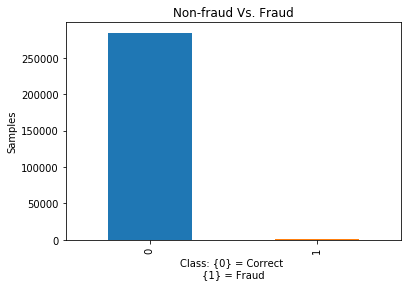

Number of Correct Samples: 284315
Number of Fraud Samples: 492
Ratio of Fraud to Correct: 0.0017304750013189597


In [50]:
#Portray the frequency of fraud
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Non-fraud Vs. Fraud")
plt.xlabel("Class: {0} = Correct \n{1} = Fraud")
plt.ylabel("Samples")
plt.show()

correct = count_classes.tolist()[0]
fraud = count_classes.tolist()[1]
print(B+"Number of Correct Samples:"+E, correct)
print(B+"Number of Fraud Samples:"+E, fraud)
print(B+"Ratio of Fraud to Correct:"+E, fraud/correct)

**Since the # of fraud samples is only 0.17% of the dataset, the data needs to be undersampled for processing classifiers.** 

**In addition 285,000 samples is way too massive to process**

**Undersample the data (with 50% fraud and 50% non-fraud) to manipulate for PCA and graphing purposes**

In [25]:
#fraud data
dff = df.loc[df.Class==1]

#fraud data w/ amount > $1 stolen
dffa = dff.loc[dff.Amount>1.0]

#fraud data with times
dfft = dff.loc[dff.Amount>1.0, 'Time']

#convert into numpy array
dft = np.asarray(dfft)
#xdlist = dfft.tolist()

#Data
X = df.loc[:, df.columns != 'Class']

#Labels
Y = df.loc[:, df.columns == 'Class']

# Number of data points in the minority class
number_records_fraud = len(df[df.Class == 1])
fraud_indices = np.array(df[df.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = df[df.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)


# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
usd = df.iloc[under_sample_indices,:]

#scramble the dataset so fraud isn't ordered first
usd = usd.sample(frac=1)

#Undersampled X data and Y labels via Class
Xu = usd.loc[:, usd.columns != 'Class'] 
Yu = usd.loc[:, usd.columns == 'Class'] # Yu == 1 then fraud otherwise 0

# Approach 1) K-Nearest Neighbor Classifier

**First obtain 2-D PCA of Data**

Create Training and Test sets for k-NN

In [33]:
#Optimize the train/test lengths (this uses 15% of data as test)
test_percent = .15
test_len = (np.floor(test_percent*len(Xu))).astype(int)
train_len = (len(Xu)-test_len).astype(int)

#Create Training Data
training_data = Xu[:train_len]
training_labels = Yu[:train_len]

#Create Test Data
test_data = Xu[train_len:]
test_labels = Yu[train_len:]

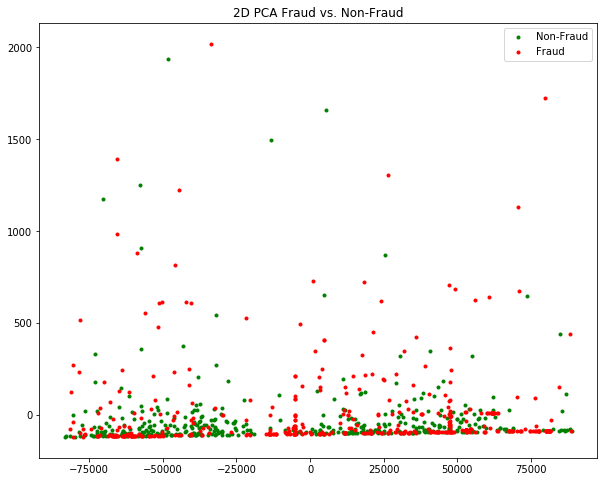

In [34]:
# Transpose the data matrix so each sample is a column
X = training_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#PCA features
X_tilde = U2.T@centered_X

#reconstruction
X_hat = U2@X_tilde + mean_mat

# Scatter plot for Fraud Vs. Non-Fraud
plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[np.where(training_labels==0),0],X_tilde.T[np.where(training_labels==0),1],c='g',marker='.',label='Non-Fraud')
plt.scatter(X_tilde.T[np.where(training_labels==1),0],X_tilde.T[np.where(training_labels==1),1],c='r',marker='.',label='Fraud')
plt.title('2D PCA Fraud vs. Non-Fraud')
plt.legend()
plt.show()

**From this 2D PCA plot, it seems that Fraud is very hard to seperate from non-fraud. However, there seems to be a lot of fraudulent class points in the center of axis = 1.**

In [35]:
##### Find the 2D PCA features of test_data set #####

# Transpose the data matrix so each sample is a column
X = test_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#X_tilde1 = 2D PCA features of test_set
X_tilde1 = U2.T@centered_X

**Creating k-NN algorithm**

In [36]:
#Create class imagelabel(image = norm, label = 0,1)
#Use for knn to sort images based on norm while keeping its label
class imagelabel:
    def __init__(self, image, label):
        self.image = image
        self.label = label
    def __repr__(self):
        return repr((self.image, self.label))

#Create k-NN function to calculate the norms to the desired 'point'
#Using closest 'k' # of points to classify labels
def knn(point,k):
    #Create a matrix to store all the norm distances w/ labels
    norm_mat = []
    
    #Use the 300 pt training_images set
    for i in range (0,train_len):
        #Use X_tilde the 2D PCA features of training_images
        #Find norm between point and training set
        norm = np.linalg.norm(point-X_tilde.T[i])
        
        #append each (norm, label) using class imagelabel(norm,label)
        if training_labels.values[i] == 0: 
            norm_mat.append(imagelabel(norm,0))
        else:
            norm_mat.append(imagelabel(norm,1))
    
    #sort based on image's closest norms
    nmsort = sorted(norm_mat, key=lambda pt: pt.image)
    
    #Create counters to determine labels for k closest pts.
    counter0 = 0
    counter1 = 0
    
    #loop through k closest points
    for i in range (0,k):
        nms = nmsort[i]
        if nms.label == 0: #if label = 0 counter0++
            counter0+=1
        else:
            counter1+=1 #else label = 1 counter1++
    
    #output 0,1 label corresponding to highest counter
    if counter0 >= counter1:
        output = 0
    else:
        output = 1
    
    #return norm matrix, sorted norm matrix, 0-1 output
    return norm_mat, nmsort, output

**Plotting k-NN Data with k = 5**

In [43]:
#create right/wrong 2D pts for plotting
xtright = []
ytright = []
xtwrong = []
ytwrong = []

#loop through the test_len to compare k-NN output to label
for i in range (0, test_len):
    nm, nm2, o = knn(X_tilde1.T[i],5)
    xn = X_tilde1.T[i,0]
    yn = X_tilde1.T[i,1]
    
    #if output = test_label then k-NN classified right
    #else classified wrong
    if o == test_labels.values[i]:
        xtright.append(xn) #append right pts for plot
        ytright.append(yn)
        #print('index',i, o, 'right')
    else:
        xtwrong.append(xn) #append wrong pts for plot
        ytwrong.append(yn)
        #print('index:',i, o, 'wrong')


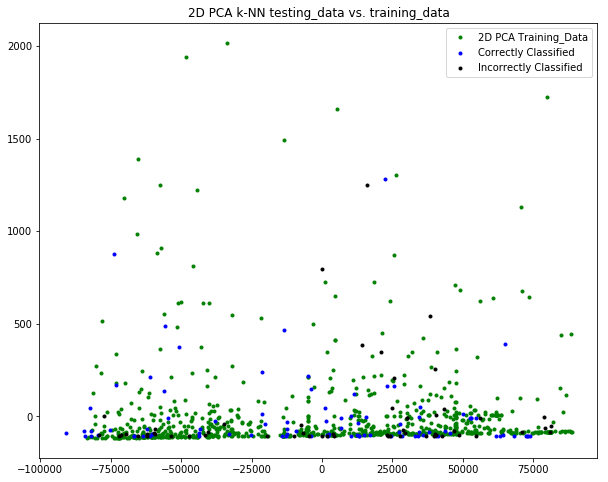

Error with k = 5: 0.3877551020408163


In [44]:
#Plotting on graph and displaying error

plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[:,0],X_tilde.T[:,1], color = 'green', marker = '.', label = '2D PCA Training_Data')
plt.scatter(xtright,ytright, color = 'blue', marker = '.', label = 'Correctly Classified')
plt.scatter(xtwrong,ytwrong, color = 'black', marker = '.', label = 'Incorrectly Classified')
plt.title('2D PCA k-NN testing_data vs. training_data')
plt.legend()
plt.show()

err = len(xtwrong)/test_len
print(B+'Error with k = 5:'+E, err)

**As shown above, k-NN is a poor model to classify this problem as the dataset does not have defining features that seperate the two classes** 

**Regular PCA feature engineering does not work. Instead the dataset requires analyzing performance metrics of the model to maximize precision. Thus, the approach of Logistic Regression Classifier is used.**

# Approach 2) Logistic Regression Classifier

In [54]:
from sklearn.cross_validation import train_test_split

X = df.iloc[:, df.columns != 'Class']
Y = df.iloc[:, df.columns == 'Class']

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(Xu
                                                                                                   ,Yu
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [62]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table
    best_c.dtypes.eq(object) # you can see the type of best_c
    new = best_c.columns[best_c.dtypes.eq(object)] #get the object column of the best_c
    best_c[new] = best_c[new].apply(pd.to_numeric, errors = 'coerce', axis=0) # change the type of object
    best_c
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter'] #calculate the mean values
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [69]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.7936507936507936
Iteration  2 : recall score =  0.8648648648648649
Iteration  3 : recall score =  0.8923076923076924
Iteration  4 : recall score =  0.855072463768116
Iteration  5 : recall score =  0.9285714285714286

Mean recall score  0.866893448632579

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.873015873015873
Iteration  2 : recall score =  0.8783783783783784
Iteration  3 : recall score =  0.9230769230769231
Iteration  4 : recall score =  0.9130434782608695
Iteration  5 : recall score =  0.9428571428571428

Mean recall score  0.9060743591178374

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8888888888888888
Iteration  2 : recall score =  0.9054054054054054
Ite

In [64]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.8742138364779874


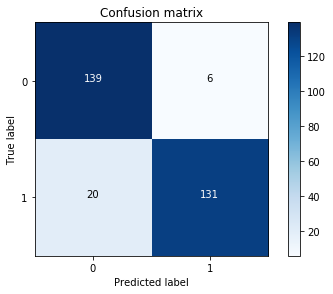

In [78]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()